# LASSO

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
if not os.path.exists("images"): 
    os.mkdir("images")
pd.set_option('display.max_columns', None)
from scipy.stats import pointbiserialr, f_oneway
from scipy.stats import boxcox

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import Normalizer

Background Info:
 - [Column Definitions](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
 - [Column Variables](https://www.kaggle.com/datasets/ahmedmohameddawoud/ames-housing-data)

Tasks:
 - <a href="#y">Y Variance (Histograms with Transformations)</a><br>
 - <a href="#f_var">Feature Variance (Histograms)</a><br>
 - <a href="#corr">Correlation Matrices</a><br>
 - <a href="#sp_corr">Feature / Salesprice Correlations</a><br>

In [3]:
housing_d = pd.read_csv('housing_cleaned.csv', index_col=0)

In [4]:
housing_d = housing_d.convert_dtypes()
housing_d = housing_d.reset_index().drop(columns = 'PID')
housing_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2559 non-null   Int64  
 1   SalePrice      2559 non-null   Int64  
 2   MSSubClass     2559 non-null   Int64  
 3   MSZoning       2559 non-null   string 
 4   LotFrontage    2559 non-null   Int64  
 5   LotArea        2559 non-null   Int64  
 6   Street         2559 non-null   string 
 7   LotShape       2559 non-null   string 
 8   LandContour    2559 non-null   string 
 9   Utilities      2559 non-null   string 
 10  LotConfig      2559 non-null   string 
 11  LandSlope      2559 non-null   string 
 12  Neighborhood   2559 non-null   string 
 13  Condition1     2559 non-null   string 
 14  Condition2     2559 non-null   string 
 15  BldgType       2559 non-null   string 
 16  HouseStyle     2559 non-null   string 
 17  OverallQual    2559 non-null   Int64  
 18  OverallC

In [268]:
continuous = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','OverallQual','OverallCond',]
print(len(continuous))
continuous_no_sp = ['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','OverallQual','OverallCond',]


continuous_wlog = ['SalePrice','GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1',
              'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt',
              'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
              'MiscVal','YrSold','SalesPrice_log','SalePrice_box','OverallQual','OverallCond',]
print(len(continuous_wlog))
categorical = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
              'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir',
              'Electrical','KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
               'PoolQC','Fence','MiscFeature','MoSold','SaleType','SaleCondition']
print(len(categorical))
len(continuous_no_sp)

35
37
43


34

<p><a name="Y"></a></p>

#### Saturated Model, No Feature Engineering

In [269]:
#OneHot Encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
df = housing_d

# Fit the encoder and transform the 'Category' column
encoded_array = encoder.fit_transform(df[categorical])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical))
encoded_df #2559x15, automatically drops the first one
df_encoded = pd.concat([df, encoded_df], axis=1)
df_encoded.drop(categorical, axis=1, inplace=True)
df_encoded#.shape #(2559, 301)

,GrLivArea,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,MapRefNo,Prop_Addr,lat,long,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSewr,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_N,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_N,BsmtQual_Po,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_N,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_N,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_N,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_N,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_Po,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_N,GarageFinish_N,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_N,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_N,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,PoolQC_N,PoolQC_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_N,MiscFeature_N,MiscFeature_Othr,Misc

In [270]:
X = df_encoded.drop(['SalePrice','MapRefNo','Prop_Addr','lat','long'], axis = 1)
y = df_encoded['SalePrice']

In [271]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [272]:
X_train.shape
# X_test
# y_train

(2047, 281)

Trial 1: Normalized with all features

In [352]:
# Define the column transformer Normalized

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_no_sp),
    ], remainder = 'passthrough')

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = .1))
])


In [353]:
# Fit the pipeline on the training data
pipeline.fit(X_train, np.log(y_train))
# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(np.log(y_test), y_pred)
r2 = r2_score(np.log(y_test), y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - np.log(y_test)))
n = X_test.shape[0]
p = X_test.shape[1] - 1  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'R^2: {r2}')
print(f'Adjusted R^2: {adjusted_r2}')
print(f'Mean Squared Error: {mse}')
print("Mean Absolute Error (MAE):", mae)
print(f'Root Mean Squared Error: {rmse}')

R^2: 0.6952715375107291
Adjusted R^2: 0.3259037041904007
Mean Squared Error: 0.047442252547355845
Mean Absolute Error (MAE): 0.16124955654898562
Root Mean Squared Error: 0.21781242514456298


Looping Alpha

In [358]:
# Testing penalization
alphas = np.linspace(0.1,10000.1,100)
coefs_lasso  = []
ltr_scores = []
lte_scores = []
ladj_scores = []
n = X_test.shape[0]
p = X_test.shape[1] - 1  # Number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

for alpha in alphas:
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_no_sp),
    ], remainder = 'passthrough')

    # Define the pipeline
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha = alpha))
    ])

    pipeline.fit(X_train, y_train)
    coefs_lasso.append(pipeline.named_steps['regressor'].coef_)
    ltr_scores.append(r2_score(y_train, pipeline.predict(X_train)))
    lte_scores.append(r2_score(y_test, pipeline.predict(X_test)))
    ladj_scores.append(1 - (1 - (r2_score(y_test, pipeline.predict(X_test)))) * (n - 1) / (n - p - 1))
    

# coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)  


/Users/katherinekwan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+11, tolerance: 1.107e+09
  model = cd_fast.enet_coordinate_descent(


<Axes: title={'center': 'Lasso Scores'}, xlabel='Alpha', ylabel='R Squared score'>

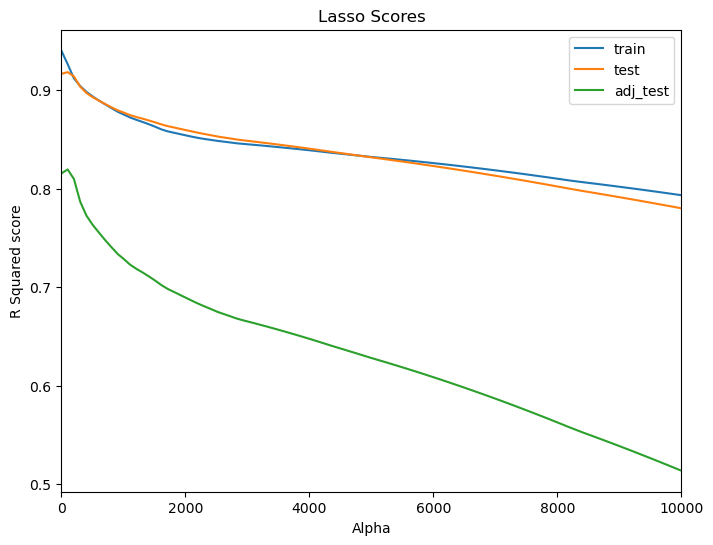

In [359]:
plt.figure(figsize=(8, 6))
scores_pd = pd.DataFrame([ltr_scores,lte_scores,ladj_scores], columns = alphas, index = ['train','test','adj_test']).T
scores_pd.train.plot(legend = True)
scores_pd.test.plot(legend = True)
scores_pd.adj_test.plot(legend = True, title = 'Lasso Scores',xlabel = 'Alpha', ylabel = 'R Squared score', xlim = (0,10000)) 
#alpha = 180 is where test and train cross. optimal. 
plt.savefig('images/Lasso_large.png')

In [336]:
scores_pd #highest Adj R Score is highest at 81.9

,train,test,adj_test
0.100000,0.940165,0.916624,0.815562
101.110101,0.926477,0.918442,0.819584
202.120202,0.912044,0.914053,0.809874
303.130303,0.904316,0.903648,0.786858
404.140404,0.898350,0.897233,0.772667
...,...,...,...
9596.059596,0.796995,0.784790,0.523929
9697.069697,0.796114,0.783636,0.521376
9798.079798,0.795223,0.782472,0.518802
9899.089899,0.794324,0.781300,0.516209


In [337]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns=X_train.columns)
# X_train.columns #281

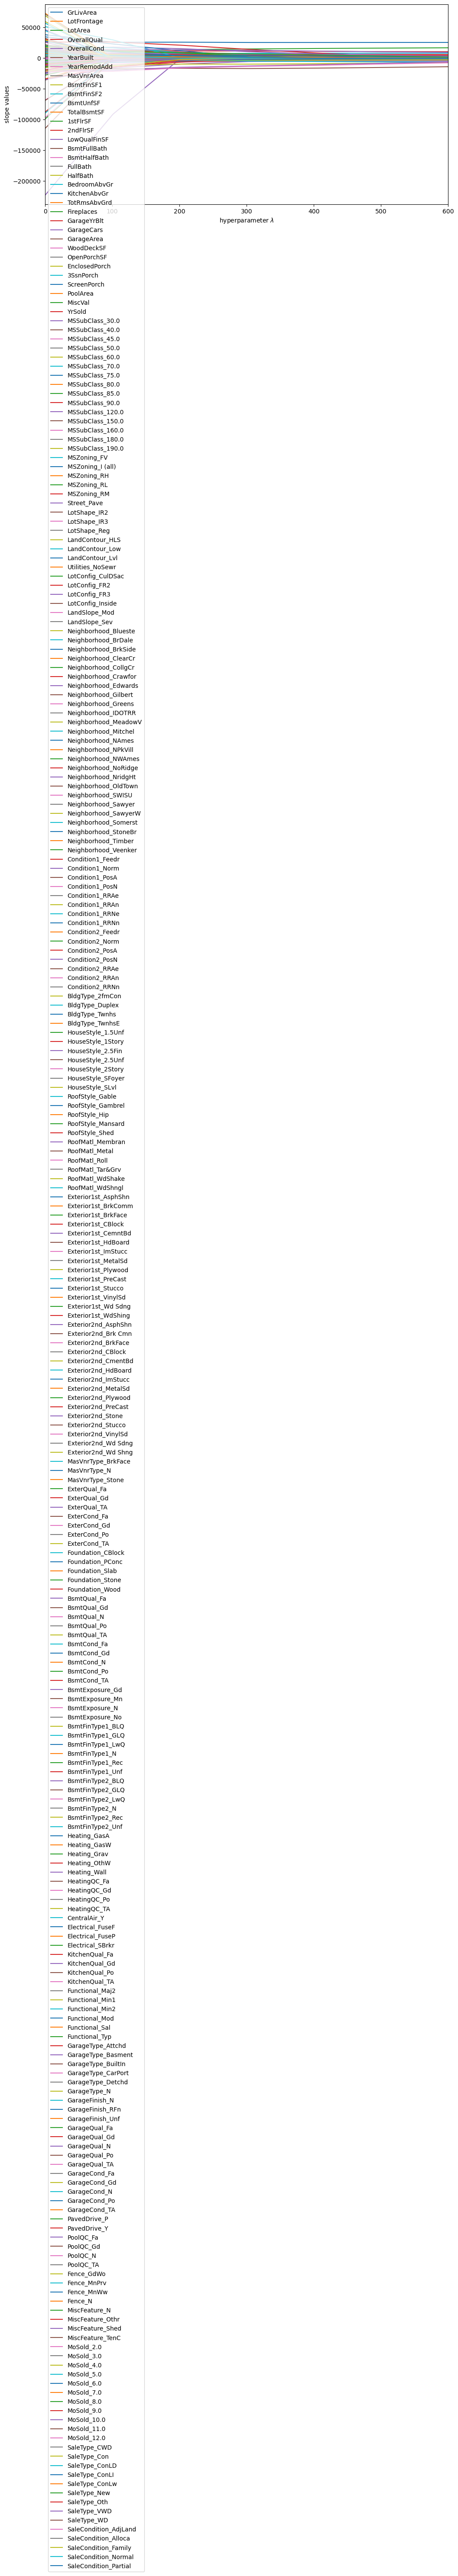

In [338]:
plt.figure(figsize=(12, 6)) 
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.xlim([0,600])

plt.legend(loc=2)   

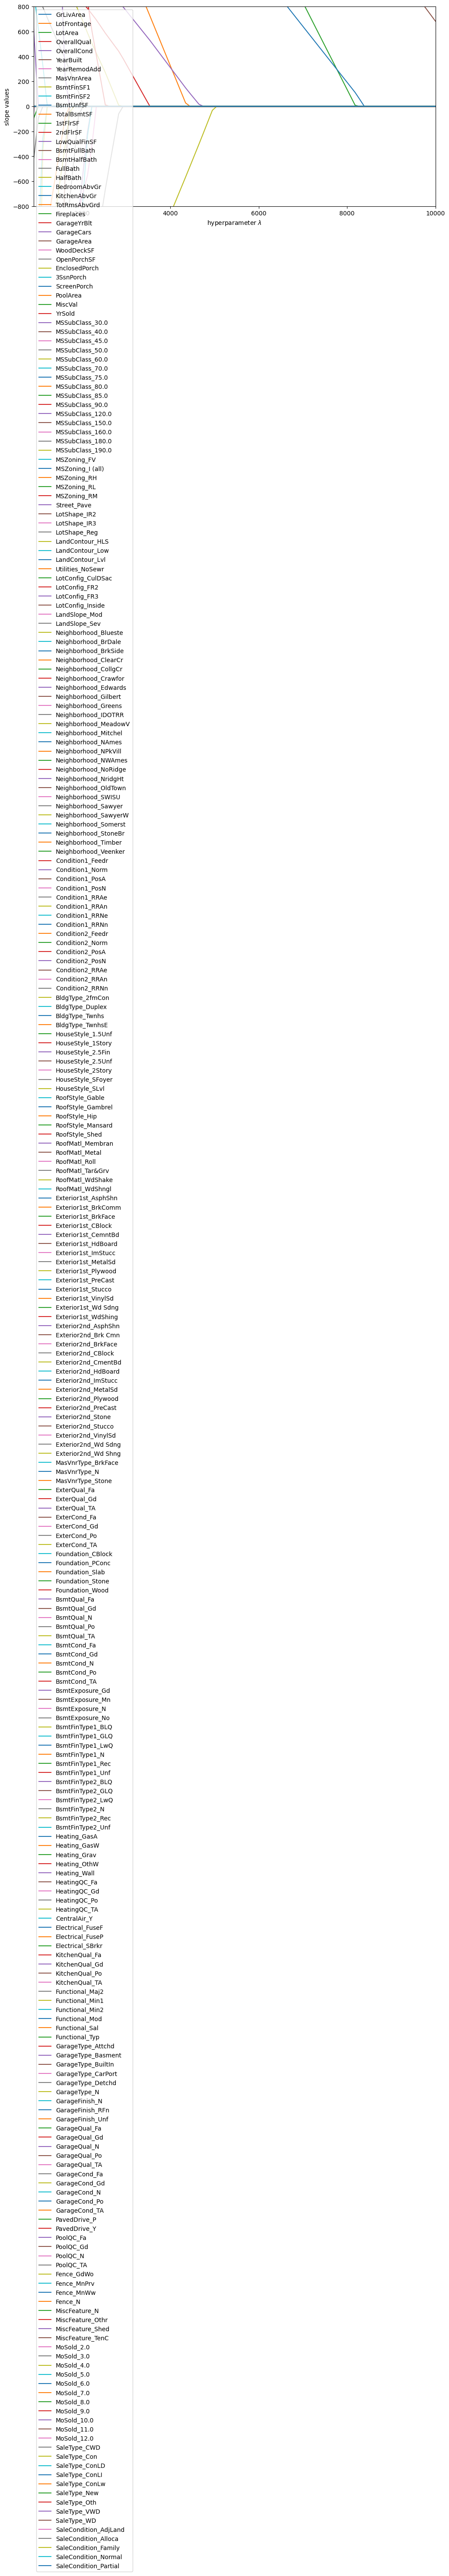

In [339]:
plt.figure(figsize=(12, 6)) 
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.xlim([900,10000])
plt.ylim([-800,800])
plt.legend(loc=2)   

In [340]:
#feature selection at alha = 10000.1
coefs_lasso.loc[10000.1,][coefs_lasso.loc[10000.1,] !=0]

GrLivArea       19917.534771
OverallQual      2067.472988
OverallCond      1246.495695
YearBuilt         681.794254
YearRemodAdd     5770.562145
BsmtFinSF2       6416.717917
BsmtUnfSF        2837.048809
Fireplaces       1166.990730
GarageYrBlt      4866.538037
MiscVal         25165.263281
Name: 10000.1, dtype: float64

Highest adjusted r squared for this line fo inquiry - MLS, selection by coefficients. 
['OverallCond',
 'OverallQual',
 'Fireplaces',
 'GarageCars',
 'FullBath',
 'YearBuilt',
 'LotFrontage']. All are continuous, which asks whether I have explored the categorical enough. 

In [333]:
def quick_mls (cont, cat=[], log = 'No'):
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), cont),
        ], remainder = 'passthrough')

    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
        ('regressor', LinearRegression())
        ])

    # Fit the pipeline on the training data
    if log == 'Yes':
        pipeline.fit(X_train[cont+cat], np.log(y_train))

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test[cont+cat])

        # Evaluate the model
        mse = mean_squared_error(np.log(y_test), y_pred)
        r2 = r2_score(np.log(y_test), y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_pred - np.log(y_test)))
        n = X_test[cont+cat].shape[0]
        p = X_test[cont+cat].shape[1] - 1  # Number of predictors
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        train_pred = pipeline.predict(X_train)
        #r2_score(np.log(y_train), train_pred)
    else:
        
        pipeline.fit(X_train[cont+cat], y_train)

        # Make predictions on the test data
        y_pred = pipeline.predict(X_test[cont+cat])

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_pred - y_test))
        n = X_test[cont+cat].shape[0]
        p = X_test[cont+cat].shape[1] - 1  # Number of predictors
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        train_pred = pipeline.predict(X_train)
        #r2_score(np.log(y_train), train_pred)
        
    print(f'R^2 of test set: {r2}')
    print(f'Adjusted R^2 of test set: {adjusted_r2}')
    print(f'Mean Squared Error: {mse}')
    print("Mean Absolute Error (MAE):", mae)
    print(f'Root Mean Squared Error: {rmse}')